In [5]:
import numpy as np 
import pandas as pd
from matplotlib import pyplot as plt
import scipy as sp
from scipy.io.wavfile import read
from glob import glob
import os
import itertools
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

In [6]:
# TensorFlow y tf.keras
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.optimizers import SGD
from keras.utils import np_utils
import scikeras
from scikeras.wrappers import KerasClassifier, KerasRegressor
from keras.models import Sequential
from keras.layers import Dense
from keras.callbacks import History, Callback, ModelCheckpoint, EarlyStopping
from keras.regularizers import L1L2

In [7]:
def preprocessing(rate, data, fft_size, label, instrument):
    """
    Convert the input audio sampled at the input rate
    to a list of HPCP vectors computed using the input fft_size
    (effectively outputing int(len(data)/fft_size)) HPCP vectors
    """
    output_samples = []
    for i in range(int(len(data)/fft_size)):
        ###Computing the DFT by taking a fragment of the audio 
        dft = np.fft.fft(data[fft_size*i:fft_size*(i+1)])
        ### Computiong the Harmonic pitch class profile
        HPCP = []
        f_ref = 130.80
        M = [round(12*np.log2(rate*l/(fft_size*f_ref))) %12 if l > 0 else -1 for l in range(int(fft_size/2))]
        M = np.array(M)
        for p in range(12):
            val = np.sum((np.absolute(dft[:int(fft_size/2)])**2)* (M == p).astype(int) )
            HPCP.append(val)
        HPCP = [x/sum(HPCP) for x in HPCP]
        output_sample = HPCP + [i, instrument, label]
        output_samples.append(output_sample)
     
    return output_samples

In [8]:
labels_dict = {
    'a':0,
    'am':1,
    'bm':2,
    'c':3,
    'd':4,
    'dm':5,
    'e':6,
    'em':7,
    'f':8,
    'g':9
}
samples = []
fft_size = 16384
clean_guitar_chords = glob('C:\\Users\\Omar\\Documents\\DeepLearning\\DLChordsNotebook\\DLChordsNotebook\\data\\Guitar_Only/*/*')
for chord in clean_guitar_chords:
    label = labels_dict[chord.split('\\')[-2]]
    instrument = 'Guitar'
    rate, data = read(chord)
    print("Estoy calculando "+chord)
    samples_temp = preprocessing(rate, data, fft_size, label, instrument)
    samples = samples + samples_temp

other_instr_chords = glob('C:\\Users\\Omar\\Documents\\DeepLearning\\DLChordsNotebook\\DLChordsNotebook\\data\\Other_Instruments/*/*/*')
for chord in other_instr_chords:
    try:
        label = labels_dict[chord.split('\\')[-2]]
        instrument = chord.split('\\')[-3] if chord.split('\\')[-3] != 'Guitar' else 'Guitar_Noisy'
        rate, data = read(chord)
        samples_temp = preprocessing(rate, data, fft_size, label, instrument)
        samples = samples + samples_temp
    except:
        pass

Estoy calculando C:\Users\Omar\Documents\DeepLearning\DLChordsNotebook\DLChordsNotebook\data\Guitar_Only\a\a1.wav
Estoy calculando C:\Users\Omar\Documents\DeepLearning\DLChordsNotebook\DLChordsNotebook\data\Guitar_Only\a\a10.wav
Estoy calculando C:\Users\Omar\Documents\DeepLearning\DLChordsNotebook\DLChordsNotebook\data\Guitar_Only\a\a100.wav
Estoy calculando C:\Users\Omar\Documents\DeepLearning\DLChordsNotebook\DLChordsNotebook\data\Guitar_Only\a\a101.wav
Estoy calculando C:\Users\Omar\Documents\DeepLearning\DLChordsNotebook\DLChordsNotebook\data\Guitar_Only\a\a102.wav
Estoy calculando C:\Users\Omar\Documents\DeepLearning\DLChordsNotebook\DLChordsNotebook\data\Guitar_Only\a\a103.wav
Estoy calculando C:\Users\Omar\Documents\DeepLearning\DLChordsNotebook\DLChordsNotebook\data\Guitar_Only\a\a104.wav
Estoy calculando C:\Users\Omar\Documents\DeepLearning\DLChordsNotebook\DLChordsNotebook\data\Guitar_Only\a\a105.wav
Estoy calculando C:\Users\Omar\Documents\DeepLearning\DLChordsNotebook\DLCh

C:\Users\Omar\AppData\Local\Temp\ipykernel_15828\3369823982.py:29: WavFileWarning: Chunk (non-data) not understood, skipping it.
  rate, data = read(chord)


In [9]:
columns = ['{}'.format(x) for x in range(12)] +['step', 'instrument', 'label']
df = pd.DataFrame(samples, columns=columns)
df.head()

,0,1,2,3,4,5,6,7,8,9,10,11,step,instrument,label
0,0.005290,0.106823,0.008569,0.013816,0.411795,0.015362,0.036798,0.014543,0.009410,0.364362,0.009016,0.004217,0,Guitar,0
1,0.006705,0.127006,0.008682,0.015580,0.351349,0.007606,0.001009,0.001746,0.008590,0.446242,0.017245,0.008242,1,Guitar,0
2,0.001034,0.041798,0.003427,0.004157,0.412305,0.013483,0.001393,0.001994,0.003698,0.509518,0.003990,0.003201,2,Guitar,0
3,0.003055,0.125677,0.011613,0.008409,0.408539,0.004442,0.014844,0.009215,0.006436,0.389792,0.006976,0.011002,0,Guitar,0
4,0.002733,0.099840,0.013896,0.012738,0.155637,0.010405,0.006699,0.007023,0.018963,0.627339,0.014537,0.030191,1,Guitar,0


In [10]:
df.to_csv('C:\\Users\\Omar\\Documents\\DeepLearning\\DLChordsNotebook\\DLChordsNotebook\\dataprocessed.csv', index=False)

In [11]:
df_guitar = df[['Guitar' in x for x in  df['instrument']]]
"""df_guitar.to_csv('C:\\Users\\KOKE\\Documents\\DLChordsNotebook\\data\\guitaronly.csv', index=False)"""
df_not_guitar = df[['Guitar' not in x for x in  df['instrument']]]
#df_not_guitar.to_csv('C:\\Users\\KOKE\\Documents\\DLChordsNotebook\\data\\notguitar.csv', index=False)
X_guitar = df_guitar[['{}'.format(x) for x in range(12)]]
#X_guitar.to_csv('C:\\Users\\KOKE\\Documents\\DLChordsNotebook\\data\\xguitar.csv', index=False)
Y_guitar = df_guitar[['step', 'instrument', 'label']]
#Y_guitar.to_csv('C:\\Users\\KOKE\\Documents\\DLChordsNotebook\\data\\yguitar.csv', index=False)
X_not_guitar = df_not_guitar[['{}'.format(x) for x in range(12)]]
Y_not_guitar = df_not_guitar[['step', 'instrument', 'label']]


X_train, X_test, Y_train, Y_test = train_test_split(X_guitar, Y_guitar, stratify=Y_guitar['label'])

#add all the other instruments to the test set
X_test = pd.concat([X_test, X_not_guitar])
Y_test = pd.concat([Y_test, Y_not_guitar])

#Create a validation set that is going to be used for early stopping
X_test_final, X_val, Y_test_final, Y_val = train_test_split(X_test, Y_test, stratify=Y_test['instrument'])

#formatting the output vector for keras
y_train = np_utils.to_categorical(Y_train['label'])
y_test_final = np_utils.to_categorical(Y_test_final['label'])
y_val = np_utils.to_categorical(Y_val['label'])

In [12]:
def create_model():
    # create model
    model = Sequential()
    model.add(Dense(35, input_shape=(X_train.shape[1],), activation='relu'))
    model.add(Dense(35, activation='relu'))
    model.add(Dense(10, activation='softmax'))
    sgd = SGD(learning_rate=0.001, momentum=0.25, decay=0.0)
    model.compile(loss='categorical_crossentropy', optimizer=sgd, metrics=['accuracy'])
    print(model.summary())
    return model


#filepath = '../data/external/weights_best.hdf5'
#model = KerasClassifier(model=create_model(), epochs=200, batch_size=1, verbose=2, )#, validation_data=(X_test, y_test))
EPOCHS = 500
batch_size = 1

model = create_model()
print('Here is a summary of this model: ')
model.summary()
#earlystop = EarlyStopping(monitor='val_accuracy', min_delta=0.0001, patience=5, \
                 #        verbose=1, mode='auto')
with tf.device('/CPU:0'):
  history = model.fit(
      X_train,
      y_train,
      batch_size = batch_size,
      epochs = EPOCHS,
      verbose = 1,
      shuffle = True,
      #steps_per_epoch = int(X_train.shape[0] / batch_size),
      validation_data = (X_val.values, y_val)
  )
#
#history = model.fit(X_train.values, y_train, callbacks = [earlystop], validation_data=(X_val.values, y_val))# model__validation_split=0.3)
#print(history.history_.keys())
# plot history
#plt.plot(history.history_['accuracy'], label='train')
##plt.plot(history.losses, label='train', alpha=.5)
#plt.plot(history.history_['val_accuracy'], label='test')
#plt.plot(history.val_losses, label='test', alpha=.5)
#plt.legend()
#plt.show()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 35)                455       
                                                                 
 dense_1 (Dense)             (None, 35)                1260      
                                                                 
 dense_2 (Dense)             (None, 10)                360       
                                                                 
Total params: 2,075
Trainable params: 2,075
Non-trainable params: 0
_________________________________________________________________
None
Here is a summary of this model: 
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 35)                455       
                                                             

In [13]:
print('Summary of the results after each epoch: ')
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail()

Summary of the results after each epoch: 


,loss,accuracy,val_loss,val_accuracy,epoch
495,0.075142,0.969689,0.317387,0.932121,495
496,0.074217,0.970748,0.332237,0.929697,496
497,0.075602,0.970616,0.337996,0.924848,497
498,0.075640,0.970218,0.345039,0.928485,498
499,0.075632,0.971807,0.335371,0.929697,499


In [14]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

58/58 [==============================] - 0s 1ms/step
[[1.73130488e-07 1.00260078e-11 5.41153895e-07 ... 9.25051153e-01
  1.85719094e-16 7.65305863e-09]
 [1.36825998e-04 4.36619957e-05 2.32401685e-12 ... 4.34748520e-20
  4.81622635e-07 1.30247774e-11]
 [1.65968373e-07 5.29882995e-13 7.12710957e-08 ... 7.61010051e-01
  8.47316670e-19 4.12367085e-10]
 ...
 [0.00000000e+00 2.30921828e-03 0.00000000e+00 ... 7.88230947e-38
  3.32521859e-06 0.00000000e+00]
 [1.60855246e-21 2.72054413e-14 9.99969244e-01 ... 1.40270618e-06
  3.10771837e-21 6.01667716e-10]
 [8.63501373e-06 1.62954311e-05 4.12731804e-25 ... 5.73694024e-06
  5.21848458e-21 6.03773645e-33]]
[7 5 7 ... 3 2 6]
Confusion matrix, without normalization
[[145   1   0   0   0   1   1   0   0   0]
 [  4 179   0   3   0   0   0   0   1   0]
 [  0   0 152   0   0   0   0   0   0   1]
 [  0   0   0 235   0   0   0   0   0   0]
 [  0   0   0   1 160  24   0   0   0   0]
 [  1   0   0   0   8 143   0   0   0   0]
 [  0   0   0   1   0   0 189  

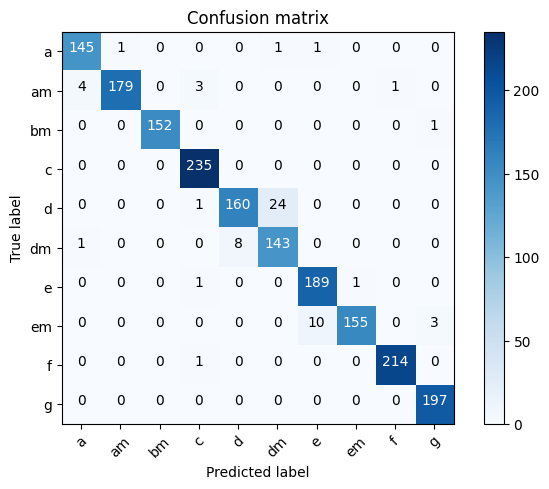

In [15]:
Y_clean_guitar = Y_test_final[Y_test_final['instrument'] == 'Guitar']
X_clean_guitar = X_test_final[Y_test_final['instrument'] == 'Guitar']
y_clean_guitar_hat = model.predict(X_clean_guitar)
print(y_clean_guitar_hat)
Y_clean_guitar = np_utils.to_categorical(Y_clean_guitar['label'])
Y_clean_guitar = np.argmax(Y_clean_guitar, axis=1)
y_clean_guitar_hat = np.argmax(y_clean_guitar_hat, axis=1)
print(y_clean_guitar_hat)

cm = confusion_matrix(Y_clean_guitar, y_clean_guitar_hat)
plot_confusion_matrix(cm, classes=labels_dict.keys(),
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues)

2/2 [==============================] - 0s 3ms/step
[8 4 4 5 8 9 2 4 6 3 6 2 3 2 1 4 3 3 9 6 8 5 0 5 6 6 9 7 1 6 0 6 9 1 7 7 3
 9 6 1 2 5 3 9 5 0 5 4 9 2 5 0 8 3 0 1 2 8]
Confusion matrix, without normalization
[[5 0 0 0 0 0 0 0 0 0]
 [0 5 0 0 0 0 0 0 0 0]
 [0 0 6 0 0 0 0 0 0 0]
 [0 0 0 7 0 0 0 0 0 0]
 [0 0 0 0 5 0 0 0 0 0]
 [0 0 0 0 0 7 0 0 0 0]
 [0 0 0 0 0 0 8 0 0 0]
 [0 0 0 0 0 0 0 3 0 0]
 [0 0 0 0 0 0 0 0 5 0]
 [0 0 0 0 0 0 0 0 0 7]]


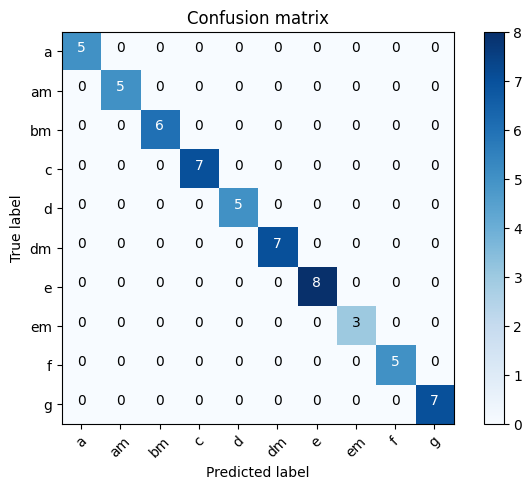

In [16]:
Y_clean_guitar = Y_test_final[Y_test_final['instrument'] == 'Guitar_Noisy']
X_clean_guitar = X_test_final[Y_test_final['instrument'] == 'Guitar_Noisy']
y_clean_guitar_hat = model.predict(X_clean_guitar)

Y_clean_guitar = np_utils.to_categorical(Y_clean_guitar['label'])
Y_clean_guitar = np.argmax(Y_clean_guitar, axis=1)
y_clean_guitar_hat = np.argmax(y_clean_guitar_hat, axis=1)
print(Y_clean_guitar)

cm = confusion_matrix(Y_clean_guitar, y_clean_guitar_hat)
plot_confusion_matrix(cm, classes=labels_dict.keys(),
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues)

In [17]:
keras_file = "DLCords1_CPU.h5"
tf.keras.models.save_model(model, keras_file)